In [1]:
import torchtext
import spacy
import pandas as pd
from torchtext.vocab import FastText
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


%matplotlib inline
import matplotlib.pyplot as plt

### Load data

In [2]:
df = pd.read_csv(r"C:\Users\ritth\code\Strive\Strive-Exercises\Chapter 03\18. Semantic Analysis\.data\Amazon\3000test.csv", nrows=3000, header=None)
df

,0,1,2,3
0,NaN,0,1,2
1,0.0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
2,1.0,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
3,2.0,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
4,3.0,2,Oh dear,I was excited to find a book ostensibly about ...
...,...,...,...,...
2995,2994.0,3,"It took a Long Time to get ""Inside the Ropes""",One of the more disappointing books by John Fe...
2996,2995.0,2,A MAJOR ( PUN INTENDED) DISAPPOINTMENT,I was so disappointed in this book. Having rea...
2997,2996.0,4,Good Inside look at the U.S. Open,The author does a great job of taking the read...
2998,2997.0,1,A Good Open Spoiled,"The subtitle should be, ""Inside the Port-o-Joh..."


### Preprocessing

In [3]:
df.drop(index= [0], inplace=True, axis=0)
df.rename({1:"star", 2:"rating1", 3:"rating2"}, axis=1, inplace=True)
df["review"] = df["rating1"] + " " +  df["rating2"]
df.drop([0, "rating1", "rating2"], inplace=True, axis=1)
df

,star,review
1,1,mens ultrasheer This model may be ok for seden...
2,4,Surprisingly delightful This is a fast read fi...
3,2,"Works, but not as advertised I bought one of t..."
4,2,Oh dear I was excited to find a book ostensibl...
5,2,"Incorrect disc! I am a big JVC fan, but I do n..."
...,...,...
2995,3,"It took a Long Time to get ""Inside the Ropes"" ..."
2996,2,A MAJOR ( PUN INTENDED) DISAPPOINTMENT I was s...
2997,4,Good Inside look at the U.S. Open The author d...
2998,1,"A Good Open Spoiled The subtitle should be, ""I..."


In [4]:
df.star = df.star.apply(lambda x: int(x)-1)
df.star.unique()

array([0, 3, 1, 2, 4], dtype=int64)

### Load dictionary

In [5]:
nlp = spacy.load("en_core_web_sm")
nlp

In [6]:
fasttext = FastText("simple")
fasttext

### Split data

In [7]:
train_df, test_df = df.iloc[:2000], df.iloc[2000:].reset_index(drop= True)
train_df.shape, test_df.shape

((2000, 2), (999, 2))

In [8]:
test_df.head()

,star,review
0,2,smaller than swaddlers order the same size fro...
1,0,lumps in the diapers i don't know if it's pamp...
2,2,Love pampers I do love pampers diapers. I was ...
3,1,contents leaking I got the replacement because...
4,2,Not very satisfied with Pampers Baby dry size ...


### Preprocessing data

In [9]:
def preprocessing(sentence):
    
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return tokens
    

### Encoder

In [10]:
def token_encoder(token, vec):
    if token == "<pad>":
        return 1
    else:
        try:
            return vec.stoi[token]
        except:
            if type(token)!=str:
                print("Error! Type of token must be a string")
            else:    
                return 0

In [11]:
def encoder(tokens, vec):
    return [token_encoder(token, vec) for token in tokens]

### Padding

In [12]:
def padding(list_of_indexes, max_seq_len, padding_index=1):
    output = list_of_indexes + (max_seq_len - len(list_of_indexes))*[padding_index]
    return output[:max_seq_len]

### Data

In [13]:
class Data(Dataset):
    def __init__(self, df, max_seq_len=32): 
        self.max_seq_len = max_seq_len
        
        train_iter = iter(df.review.values)
        self.vec = FastText("simple")
        self.vec.vectors[1] = -torch.ones(self.vec.vectors[1].shape[0]) 
        self.vec.vectors[0] = torch.zeros(self.vec.vectors[0].shape[0]) 
        self.vectorizer = lambda x: self.vec.vectors[x]
        self.labels = df.star
        sequences = [padding(encoder(preprocessing(sequence), self.vec), max_seq_len) for sequence in df.review.tolist()]
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]

In [14]:
train_dataset = Data(train_df)
test_dataset = Data(test_df)

In [15]:
train_dataset

### Collate

In [16]:
def traincollate(batch, vectorizer = train_dataset.vectorizer):

    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch])

    return inputs, target

In [17]:
def testcollate(batch, vectorizer = test_dataset.vectorizer):

    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch]) 
    
    return inputs, target

In [18]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn= traincollate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn= testcollate)

In [19]:
train_loader

In [20]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [23]:
s, l = next(train_iter)
print(s.shape)

torch.Size([16, 32, 300])


### Model

In [24]:
emb_dim = 300
class Classifier(nn.Module):
    def __init__(self, max_seq_len, emb_dim, hidden1=16, hidden2=16):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(max_seq_len*emb_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 5)
        self.out = nn.LogSoftmax(dim=1)
    
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.out(x)

In [25]:

model = Classifier(32, 300)
model

Classifier(
  (fc1): Linear(in_features=9600, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
  (out): LogSoftmax(dim=1)
)

In [26]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

### Training and Validation

Epoch: 1/3
	Iteration: 0	 Loss: 0.0397
	Iteration: 40	 Loss: 0.0399
	Iteration: 80	 Loss: 0.0404
	Iteration: 120	 Loss: 0.0402
Epoch: 2/3
Epoch: 3/3


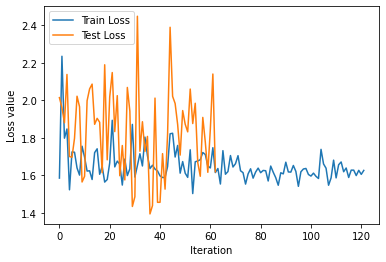

In [27]:
epochs = 3
print_every = 40
train_losses = []
test_losses = []


for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (sentences, labels) in enumerate(train_iter):

        sentences.resize_(sentences.size()[0], 32* emb_dim)
        
        model.train()
        optimizer.zero_grad()
        
        output = model.forward(sentences)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        train_losses.append(loss.detach().item())
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

        
        model.eval()
        with torch.no_grad():
            running_loss = 0

            for i, (test_sentences, test_labels) in enumerate(test_iter):
                test_sentences.resize_(test_sentences.size()[0], 32* emb_dim)

                test_out = model.forward(test_sentences)
                test_loss = criterion(test_out, test_labels)
                running_loss += test_loss.item()
                test_losses.append(test_loss.detach().item())

        model.train()



plt.plot(train_losses, label= "Train Loss")
plt.plot(test_losses, label= "Test Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()